# Item Categorization using MLP Classifier

***

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import re
from sklearn.utils import shuffle
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# RUN ONLY ONCE
# os.chdir is used to change the current directory to the specified path
os.chdir("../..") # Sets path to the repo folder as it is one level above where this file exists!
path = os.getcwd()
print(path)

/Users/vivaanwadhwa/Documents/GitHub/CFFS_sharon_2024


## Reading in Data

***

In [3]:
categorized_items = pd.read_csv("data/mapping/Mapping.csv")
# Filter out the items that come under manually adjusted
categorized_items = categorized_items[categorized_items["CategoryID"] != 59]
categorized_items.drop(columns=["ItemId","CaseQty","CaseUOM","PakQty","PakUOM","Active Total Supply Chain Emissions (kg CO2 / kg food)","g N lost/kg product","Land Use (m^2)","Freshwater Withdrawals (L/FU)","Stress-Weighted Water Use (L/FU)"], inplace=True)
categorized_items

,CategoryID,Description,InventoryGroup,Food Category_y
0,1.0,CHUCK FLAT BONELESS FZN,MEAT,beef & buffalo meat
1,1.0,BEEF STIRFRY COV FR,MEAT,beef & buffalo meat
2,1.0,BEEF OUTSIDE FLAT AAA,MEAT,beef & buffalo meat
3,1.0,BEEF MEATBALLS,MEAT,beef & buffalo meat
4,1.0,BEEF INSIDE ROUND SHAVED,MEAT,beef & buffalo meat
...,...,...,...,...
3018,38.0,RADISH BUNCH,PRODUCE,root vegetables
3019,62.0,SAL SOCKEYE SMK TRIM OW,SEAFOOD,Salmon trout (wild)
3020,3.0,SOPPRESSATA MILD MASTRO,DELI & PREPARED MEAT,pork (pig meat)
3022,20.0,TOFU MEDIUM RED,FOOD - GROCERY,soybeans/tofu


In [4]:
def improved_preprocessing(text):
    # Implement more sophisticated text cleaning
    text = text.lower()
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenization with more context preservation
    tokens = text.split()
    
    # Use lemmatization instead of simple stemming
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Remove very common stop words specific to food context
    stop_words = set(['the', 'a', 'an', 'and', 'or', 'but'] + 
                     ['product', 'item', 'food', 'type'])
    tokens = [token for token in tokens if token not in stop_words]
    
    return ' '.join(tokens)

categorized_items['CleanedDescription'] = categorized_items['Description'].apply(improved_preprocessing)
categorized_items

,CategoryID,Description,InventoryGroup,Food Category_y,CleanedDescription
0,1.0,CHUCK FLAT BONELESS FZN,MEAT,beef & buffalo meat,chuck flat boneless fzn
1,1.0,BEEF STIRFRY COV FR,MEAT,beef & buffalo meat,beef stirfry cov fr
2,1.0,BEEF OUTSIDE FLAT AAA,MEAT,beef & buffalo meat,beef outside flat aaa
3,1.0,BEEF MEATBALLS,MEAT,beef & buffalo meat,beef meatball
4,1.0,BEEF INSIDE ROUND SHAVED,MEAT,beef & buffalo meat,beef inside round shaved
...,...,...,...,...,...
3018,38.0,RADISH BUNCH,PRODUCE,root vegetables,radish bunch
3019,62.0,SAL SOCKEYE SMK TRIM OW,SEAFOOD,Salmon trout (wild),sal sockeye smk trim ow
3020,3.0,SOPPRESSATA MILD MASTRO,DELI & PREPARED MEAT,pork (pig meat),soppressata mild mastro
3022,20.0,TOFU MEDIUM RED,FOOD - GROCERY,soybeans/tofu,tofu medium red


In [5]:
def improved_domain_term_removal(text):
    # More nuanced approach
    patterns = {
        # Terms to remove completely
        'remove_full': [
            'gluten free', 'gf', 'g/f', 
            'vegan', 'non dairy', 
            'sugar free', 'low fat',
        ],
        # Terms to replace with space
        'replace_with_space': [
            'frozen', 'fzn', 'fresh', 
            'dried', 'organic', 'org'
        ],
        # Contextual number handling
        'number_handling': {
            'remove_units': ['kg', 'g', 'oz', 'lb', 'lbs', 'ct', 'pk'],
            'keep_contextual_numbers': True
        }
    }
    
    # Remove full match terms
    for term in patterns['remove_full']:
        text = re.sub(r'\b' + re.escape(term) + r'\b', '', text, flags=re.IGNORECASE)
    
    # Replace with space
    for term in patterns['replace_with_space']:
        text = re.sub(r'\b' + re.escape(term) + r'\b', ' ', text, flags=re.IGNORECASE)
    
    # Contextual number handling
    if patterns['number_handling']['keep_contextual_numbers']:
        # Remove only specific units, preserve other numbers
        for unit in patterns['number_handling']['remove_units']:
            text = re.sub(r'\d+\s*' + re.escape(unit), '', text, flags=re.IGNORECASE)
    else:
        # Remove all numbers
        text = re.sub(r'\d+', '', text)
    
    # Remove extra special characters, but preserve meaningful ones
    text = re.sub(r'[%\(\)=]', '', text)
    
    # Normalize whitespace
    text = ' '.join(text.split())
    
    return text.strip()
# Apply the function to the descriptions column
categorized_items['CleanedDescription'] = categorized_items['CleanedDescription'].apply(improved_domain_term_removal)
categorized_items

,CategoryID,Description,InventoryGroup,Food Category_y,CleanedDescription
0,1.0,CHUCK FLAT BONELESS FZN,MEAT,beef & buffalo meat,chuck flat boneless
1,1.0,BEEF STIRFRY COV FR,MEAT,beef & buffalo meat,beef stirfry cov fr
2,1.0,BEEF OUTSIDE FLAT AAA,MEAT,beef & buffalo meat,beef outside flat aaa
3,1.0,BEEF MEATBALLS,MEAT,beef & buffalo meat,beef meatball
4,1.0,BEEF INSIDE ROUND SHAVED,MEAT,beef & buffalo meat,beef inside round shaved
...,...,...,...,...,...
3018,38.0,RADISH BUNCH,PRODUCE,root vegetables,radish bunch
3019,62.0,SAL SOCKEYE SMK TRIM OW,SEAFOOD,Salmon trout (wild),sal sockeye smk trim ow
3020,3.0,SOPPRESSATA MILD MASTRO,DELI & PREPARED MEAT,pork (pig meat),soppressata mild mastro
3022,20.0,TOFU MEDIUM RED,FOOD - GROCERY,soybeans/tofu,tofu medium red


In [6]:
categorized_items["CategoryID"].value_counts()

CategoryID
24.0    441
55.0    268
40.0    178
54.0    137
58.0    108
31.0     96
6.0      89
3.0      69
61.0     68
36.0     66
7.0      63
26.0     61
41.0     61
38.0     55
1.0      53
43.0     50
4.0      48
17.0     47
25.0     40
12.0     37
21.0     33
52.0     33
10.0     33
9.0      33
20.0     32
39.0     32
34.0     31
23.0     30
37.0     30
35.0     30
32.0     25
22.0     23
57.0     21
11.0     16
44.0     15
30.0     14
18.0     14
13.0     14
53.0     13
50.0     12
8.0      11
33.0     11
16.0     11
42.0      8
56.0      8
5.0       8
49.0      7
2.0       7
14.0      7
51.0      6
19.0      5
28.0      5
48.0      4
27.0      2
15.0      2
60.0      1
63.0      1
62.0      1
Name: count, dtype: int64

In [7]:
categorized_items["CleanedDescription"].to_csv("processed_mapping.csv", index=False)

In [8]:
(categorized_items["CategoryID"] == None).hasnans

False

In [9]:
X = categorized_items.drop(columns=["CategoryID", "Food Category_y", "Description"])
y = categorized_items["CategoryID"]

display(X.head(20))
display(y.head(20))

,InventoryGroup,CleanedDescription
0,MEAT,chuck flat boneless
1,MEAT,beef stirfry cov fr
2,MEAT,beef outside flat aaa
3,MEAT,beef meatball
4,MEAT,beef inside round shaved
5,MEAT,beef chuck ground aaa
6,MEAT,beef bone knuckle fz
7,MEAT,beef stew
8,MEAT,beef stew diced fr
9,MEAT,brisket beef corn smkd fr


0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
Name: CategoryID, dtype: float64

In [10]:
y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: CategoryID, dtype: float64

### Splitting into Train and Test

In [11]:
# Drop rows where y is NaN
print(X.shape)
X = X[y.notna()]
y = y.dropna()
print(X.shape)

X, y = shuffle(X, y, random_state=42)

## Train test split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(2625, 2)
(2624, 2)


In [12]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights to address imbalance
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to a readable dictionary format
class_weights = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights_array)}


/var/folders/bq/zkgc6_d969x_x5nsl5fy0vkh0000gn/T/ipykernel_54282/1023068409.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=class_frequencies, palette="viridis")


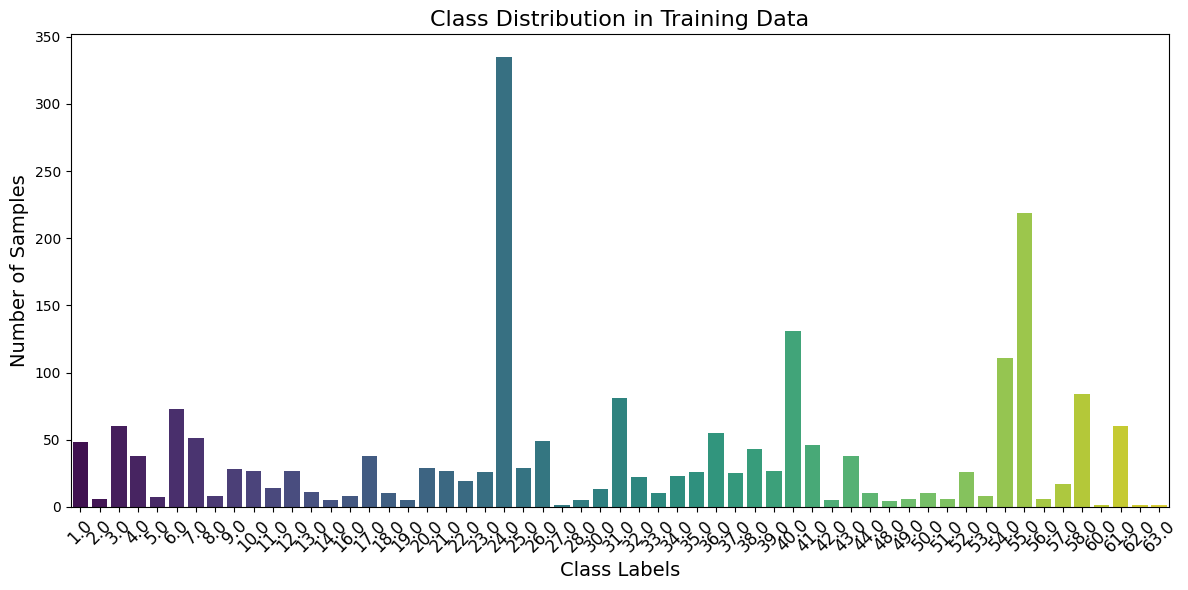

In [13]:
# Create a DataFrame for visualization
class_counts = pd.Series(y_train).value_counts().sort_index()  # Count the number of samples per class
class_labels = class_counts.index
class_frequencies = class_counts.values

# Plot the class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels, y=class_frequencies, palette="viridis")

# Add labels and title
plt.xlabel("Class Labels", fontsize=14)
plt.ylabel("Number of Samples", fontsize=14)
plt.title("Class Distribution in Training Data", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


As we can see, some classes are highly underrepresented and some are extremely overrepresented. This can lead to overfitting anf underfitting respectively. 

## Preprocessing and Training

***

In [12]:
# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('desc', TfidfVectorizer(max_features=100, ngram_range=(1,2), stop_words="english"), 'CleanedDescription'),
        ('inv_grp', OneHotEncoder(handle_unknown="ignore"), ['InventoryGroup'])
    ])

# Display the preprocessor
preprocessor

ColumnTransformer(transformers=[('desc',
                                 TfidfVectorizer(max_features=100,
                                                 ngram_range=(1, 2),
                                                 stop_words='english'),
                                 'CleanedDescription'),
                                ('inv_grp',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['InventoryGroup'])])

### MLP Classifier

In [13]:
pipeline_MLP = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', MLPClassifier(hidden_layer_sizes=(100,100), max_iter=1000, random_state=42))])

pipeline_MLP.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('desc',
                                                  TfidfVectorizer(max_features=100,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'CleanedDescription'),
                                                 ('inv_grp',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['InventoryGroup'])])),
                ('classifier',
                 MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000,
                               random_state=42))])

## Logistic Regression

In [14]:
pipeline_logistic = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
pipeline_logistic.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('desc',
                                                  TfidfVectorizer(max_features=100,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'CleanedDescription'),
                                                 ('inv_grp',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['InventoryGroup'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

## Multinomial NB

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# Define the pipeline with MultinomialNB
pipeline_NB = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB())
])

# Define the parameter grid for hyperparameter optimization
param_grid = {
    'classifier__alpha': [0.1, 0.5, 1.0],  # Smoothing parameter for MultinomialNB
    'preprocessor__desc__max_features': [50, 100, 150],  # Vocabulary size for TfidfVectorizer
    'preprocessor__desc__ngram_range': [(1, 1), (1, 2)]  # Unigrams or bigrams for TfidfVectorizer
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(pipeline_NB, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Display the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

/Users/vivaanwadhwa/Documents/GitHub/CFFS_sharon_2024/cffs/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'classifier__alpha': 0.1, 'preprocessor__desc__max_features': 150, 'preprocessor__desc__ngram_range': (1, 1)}
Best cross-validation score: 0.7217888396408683


## Testing Accuracy

In [16]:
y_pred_MLP = pipeline_MLP.predict(X_test)

accuracy_score(y_test, y_pred_MLP)

0.660952380952381

In [17]:
y_pred_logistic = pipeline_logistic.predict(X_test)

accuracy_score(y_test, y_pred_logistic)

0.6819047619047619

In [18]:
y_pred_NB = grid_search.predict(X_test)

accuracy_score(y_test, y_pred_NB)

0.7123809523809523

In [19]:
results = pd.DataFrame({'Actual': y_test, 'Predicted_MLP': y_pred_MLP, 'Predicted_Logistic': y_pred_logistic,"Predicted NB": y_pred_NB, 'CleanedDescription': X_test['CleanedDescription'], "InventoryGroup": X_test['InventoryGroup']})  
category_descriptions = pd.read_csv("data/external/ghge_factors.csv")
for index, row in results.iterrows():
    results.at[index, 'Actual Description'] = category_descriptions[category_descriptions['Category ID'] == row['Actual']]['Food Category'].values[0]
    results.at[index, 'Predicted Description MLP'] = category_descriptions[category_descriptions['Category ID'] == row['Predicted_MLP']]['Food Category'].values[0]
    results.at[index, 'Predicted Description Logistic'] = category_descriptions[category_descriptions['Category ID'] == row['Predicted_Logistic']]['Food Category'].values[0]
    results.at[index, 'Predicted Description NB'] = category_descriptions[category_descriptions['Category ID'] == row['Predicted NB']]['Food Category'].values[0]
results = results[(results["Actual"] != results["Predicted NB"])]
results

,Actual,Predicted_MLP,Predicted_Logistic,Predicted NB,CleanedDescription,InventoryGroup,Actual Description,Predicted Description MLP,Predicted Description Logistic,Predicted Description NB
2005,18.0,16.0,52.0,16.0,pea green wasabi bulk,CANDIES SNACKS,peas,other legumes,cocoa,other legumes
2959,21.0,26.0,54.0,54.0,seed chia white,SPICES,other grains/cereals,tree nuts and seeds,stimulants & spices misc.,stimulants & spices misc.
635,24.0,58.0,24.0,58.0,coyote pancake mix,FOOD - GROCERY,"wheat/rye (bread, pasta, baked goods)",sauces & paste,"wheat/rye (bread, pasta, baked goods)",sauces & paste
2239,40.0,24.0,24.0,24.0,gg wrap veg feta,PRODUCTION FOOD,other vegetables,"wheat/rye (bread, pasta, baked goods)","wheat/rye (bread, pasta, baked goods)","wheat/rye (bread, pasta, baked goods)"
789,34.0,36.0,36.0,40.0,blackberry bc,PRODUCE,berries,cabbages and other brassicas (broccoli),cabbages and other brassicas (broccoli),other vegetables
...,...,...,...,...,...,...,...,...,...,...
1397,56.0,56.0,54.0,54.0,salt kosher windsor,SPICES,salt,salt,stimulants & spices misc.,stimulants & spices misc.
2607,34.0,55.0,55.0,55.0,steaz blueberry pom acai,BEVERAGE,berries,water & beverages,water & beverages,water & beverages
2166,24.0,23.0,23.0,23.0,bar kind chewy peanutbutter,CANDIES SNACKS,"wheat/rye (bread, pasta, baked goods)",oats (oatmeal),oats (oatmeal),oats (oatmeal)
953,40.0,36.0,36.0,36.0,spinach baby u,PRODUCE,other vegetables,cabbages and other brassicas (broccoli),cabbages and other brassicas (broccoli),cabbages and other brassicas (broccoli)


In [20]:
results.to_csv("MLP_vs_Logistic.csv", index=False)

## AI Approach

***